In [1]:
import pandas as pd
import numpy as np

import keras
from keras import layers
from keras import models
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, image
from keras.applications import mobilenet_v2
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from keras import backend as K

import math
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import glob
import os
from pathlib import Path
import shutil

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root = '/content/drive/MyDrive/Education/Data Science/6. Deep Learning/data'

In [5]:
train_dir = root + '/train'
validation_dir = root + '/valid'
test_dir = root + '/test'

In [6]:
species = os.listdir(train_dir)

counts = []
birds = [] # This list is needed because there are DS_Store files lurking around so we need to ignore these
for bird in species:
  if bird[0] != '.':
    birds += [bird]
    counts += [len(os.listdir(train_dir + '/' + bird))]

counts = {v:k for v,k in zip(birds, counts)}
[print(f'{x}: {counts[x]}') for x in birds[:5]];

print('\n')

# Sort the result
counts = pd.Series(counts).sort_values(ascending=False)
counts.to_pickle(root + '/counts')
print('Top species by number of training images')
print(counts[:5])

HOOPOES: 125
AMERICAN REDSTART: 139
EASTERN TOWEE: 127
KOOKABURRA: 143
IBERIAN MAGPIE: 159


Top species by number of training images
HOUSE FINCH          249
D-ARNAUDS BARBET     233
OVENBIRD             233
SWINHOES PHEASANT    217
WOOD DUCK            214
dtype: int64


In [7]:
# Based on https://stackoverflow.com/questions/60448904/use-only-n-images-using-imagedatagenerator-from-each-class but for number of species

# This function lets us loop through the data until we reach the desired number of classes for the classes with the highest number of training images
def get_data(data_dir, species, n=5):
  species = list(species.index)[:n]
  a=[]
  for i, directory in enumerate(os.listdir(data_dir)):
    if directory[0] != '.' and directory in species:
        for bird in os.listdir(data_dir+'/'+directory):
            a.append((f'{data_dir}/{directory}/{bird}',directory))
        if i == n - 1: return pd.DataFrame(a,columns=['filename','class'])
    else: n += 1

In [8]:
get_data(train_dir, counts, 2)

,filename,class
0,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
1,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
2,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
3,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
4,/content/drive/MyDrive/Education/Data Science/...,D-ARNAUDS BARBET
...,...,...
477,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH
478,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH
479,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH
480,/content/drive/MyDrive/Education/Data Science/...,HOUSE FINCH


In [9]:
train_data = get_data(train_dir, counts, 2)

In [10]:
# Looping through the training data will collect different species than looping through the valid and test data so we need a function that will collect the proper valid/test data
def get_valid_test_data(df, data_dir):
  a = []
  classes = df['class'].unique()
  for class_ in classes:
    if class_[0] != '.':
      directory =  data_dir + '/' + class_
      for species in os.listdir(directory):
        a.append((f'{directory}/{species}',class_))
  return pd.DataFrame(a, columns=['filename','class'])

In [11]:
valid_data = get_valid_test_data(train_data, validation_dir)

In [12]:
test_data = get_valid_test_data(train_data, test_dir)

In [13]:
train_data.to_pickle(root + '/train_data')
valid_data.to_pickle(root + '/valid_data')
test_data.to_pickle(root + '/test_data')

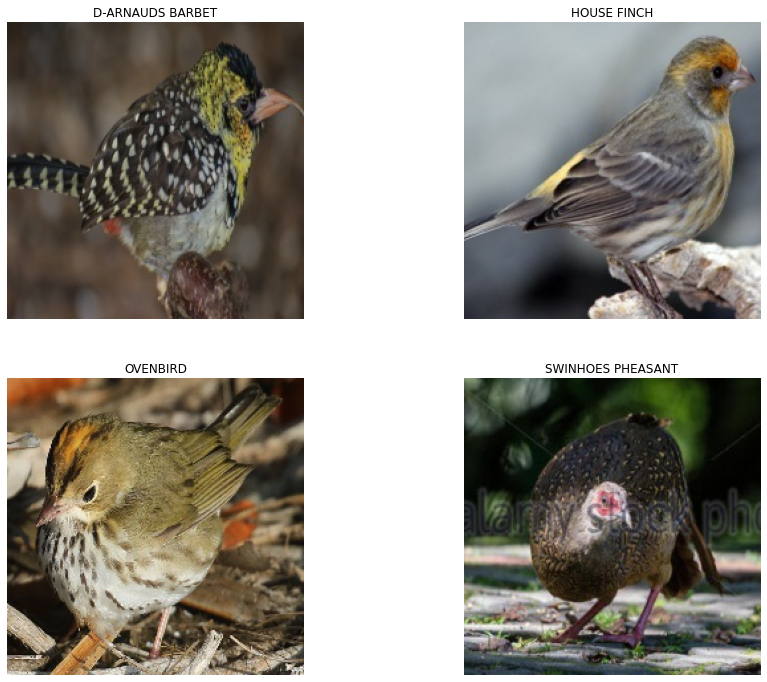

In [14]:
train = get_data(train_dir, counts, 4)
train = train.groupby('class')['filename'].first()

fig, ax = plt.subplots(2, 2, figsize=(15,12))
for i, path in enumerate(train):
  plt.subplot(2,2,i + 1)
  img = Image.open(path)
  plt.imshow(img)
  img.close()
  plt.axis('off')
  plt.title(list(train.index)[i])

In [15]:
#@title

# https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb

def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(100, activation='relu'))

  return model

#### We will add the below commented layers later once we know the number of classes we want to use.

# model.add(layers.Dense(train_data['class'].nunique(), activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam', metrics=['acc'])

In [16]:
#@title

def run_model(**params):

  # collect data
  train_data = get_data(train_dir, counts, params['num_species'])
  valid_data = get_valid_test_data(train_data, validation_dir)
  test_data = get_valid_test_data(train_data, test_dir)

# create data generators to including augmentation
  # https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb
  train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=params['horizontal_flip'], rotation_range=params['rotation_range'])
  val_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=params['horizontal_flip'], rotation_range=params['rotation_range'])

  train_generator = train_datagen.flow_from_dataframe(
          train_data,
          directory = None,
          x_col = 'filename',
          y_col = 'class',
          target_size=(224, 224),
          batch_size=params['train_batch_size'],
          class_mode='categorical')

  validation_generator = val_datagen.flow_from_dataframe(
          valid_data,
          directory = None,
          x_col = 'filename',
          y_col = 'class',
          target_size=(224, 224),
          batch_size=params['valid_batch_size'],
          class_mode='categorical')
  
  # Finish building model by adding a final layer with the number of nodes corresponding to number of bird species
  model = params['model']
  model.add(layers.Dense(train_data['class'].nunique(), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  model.summary()

  # Set step size
  # https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
  STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
  STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
  history = params['model'].fit_generator(generator=train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=validation_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=params['num_epochs'])
  
  # Save model
  num_species = params['num_species']
  augmented = str(bool(params['horizontal_flip']))
  model.save(root + f'/num_species_{num_species}_aug_{augmented}.h5')
  
  # https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(10,7))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.gca().set_ylim([0,1])
  plt.title('Training and validation accuracy', fontsize=18)
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Accuracy', fontsize=14)
  plt.legend()

  plt.figure(figsize=(10,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.gca().set_ylim([0,1])
  plt.title('Training and validation loss', fontsize=18)
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Loss', fontsize=14)
  plt.legend()

  plt.show()

In [46]:
params = {}
params['num_species'] = 2
params['num_epochs'] = 10
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 482 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 121, 121, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 59, 59, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 57, 57, 128)       73856     
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
16/16 [==============================] - 73s 4s/step - loss: 0.7804 - acc: 0.4956 - val_loss: 0.6903 - val_acc: 0.5000
Epoch 2/10
16/16 [==============================] - 49s 3s/step - loss: 0.6026 - acc: 0.6792 - val_loss: 0.3352 - val_acc: 0.8000
Epoch 3/10
16/16 [==============================] - 49s 3s/step - loss: 0.4171 - acc: 0.8473 - val_loss: 0.2710 - val_acc: 1.0000
Epoch 4/10
16/16 [==============================] - 49s 3s/step - loss: 0.2312 - acc: 0.9159 - val_loss: 0.2887 - val_acc: 0.9000
Epoch 5/10
16/16 [==============================] - 49s 3s/step - loss: 0.2008 - acc: 0.9181 - val_loss: 0.1763 - val_acc: 0.9000
Epoch 6/10
16/16 [==============================] - 49s 3s/step - loss: 0.2615 - acc: 0.9027 - val_loss: 0.3956 - val_acc: 0.8000
Epoch 7/10
16/16 [==============================] - 48s 3s/step - loss: 0.1495 - acc: 0.9491 - val_loss: 0.2726 - val_acc: 0.9000
Epoch 8/10
16/16 [==============================] - 49s 3s/step - loss: 0.1863 - acc: 0.94

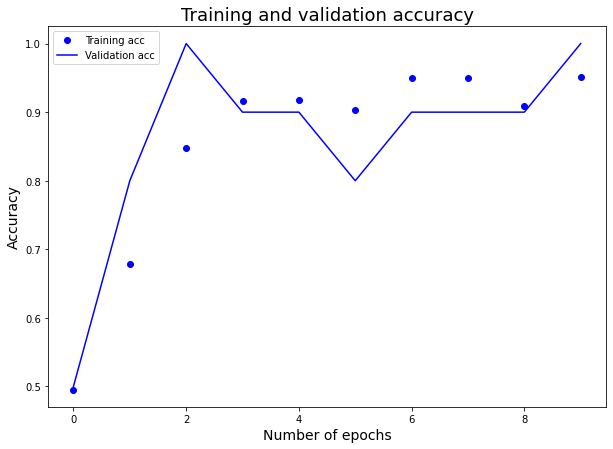

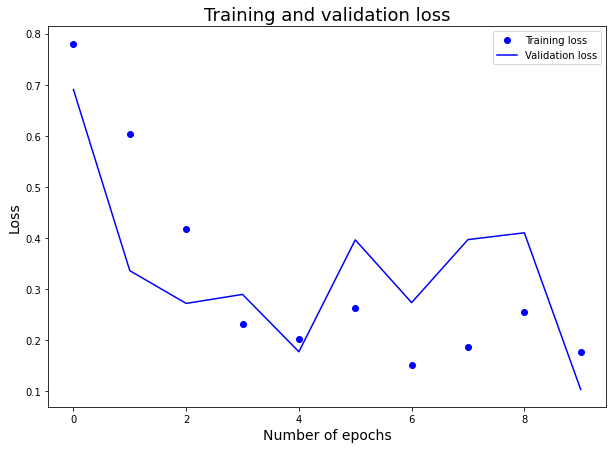

In [47]:
run_model(**params)

Increase the number of epochs to 30 to allow for more training.

In [48]:
params = {}
params['num_species'] = 2
params['num_epochs'] = 30
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['model'] = create_model()
params['horizontal_flip'] = False
params['rotation_range'] = False # set between 0 and 45 degrees

Found 482 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 121, 121, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 59, 59, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 57, 57, 128)       73856     
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
16/16 [==============================] - 50s 3s/step - loss: 0.8001 - acc: 0.5243 - val_loss: 0.6810 - val_acc: 0.5000
Epoch 2/30
16/16 [==============================] - 49s 3s/step - loss: 0.6063 - acc: 0.6659 - val_loss: 0.4212 - val_acc: 0.8000
Epoch 3/30
16/16 [==============================] - 49s 3s/step - loss: 0.3738 - acc: 0.8695 - val_loss: 0.3357 - val_acc: 0.9000
Epoch 4/30
16/16 [==============================] - 49s 3s/step - loss: 0.2506 - acc: 0.9226 - val_loss: 0.1594 - val_acc: 0.9000
Epoch 5/30
16/16 [==============================] - 50s 3s/step - loss: 0.3697 - acc: 0.8673 - val_loss: 0.2350 - val_acc: 0.9000
Epoch 6/30
16/16 [==============================] - 49s 3s/step - loss: 0.2486 - acc: 0.9204 - val_loss: 0.2118 - val_acc: 0.9000
Epoch 7/30
16/16 [==============================] - 48s 3s/step - loss: 0.1863 - acc: 0.9358 - val_loss: 0.1092 - val_acc: 1.0000
Epoch 8/30
16/16 [==============================] - 48s 3s/step - loss: 0.1545 - acc: 0.93

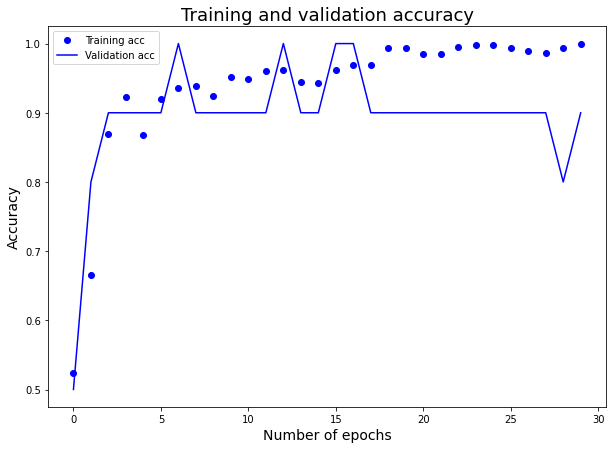

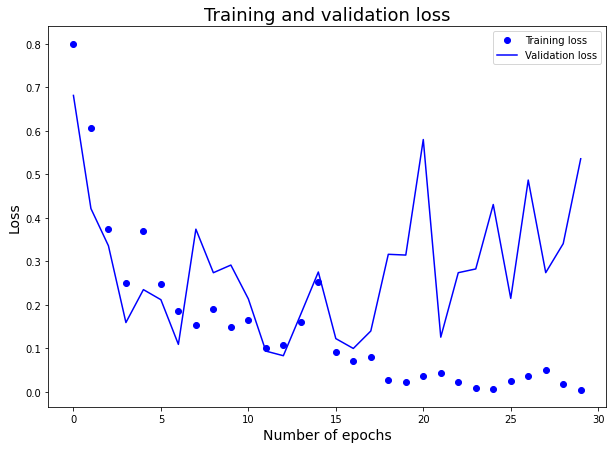

In [49]:
run_model(**params)

Repeat with 30 epochs and but turn on image augmentation (flipping and rotating). Then, increase number of classes to 4.

In [50]:
params = {}
params['num_species'] = 2
params['num_epochs'] = 30
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['model'] = create_model()
params['horizontal_flip'] = True
params['rotation_range'] = 45 # set between 0 and 45 degrees

Found 482 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 121, 121, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 59, 59, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 57, 57, 128)       73856     
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
16/16 [==============================] - 56s 3s/step - loss: 0.7255 - acc: 0.5199 - val_loss: 0.7037 - val_acc: 0.5000
Epoch 2/30
16/16 [==============================] - 55s 3s/step - loss: 0.6378 - acc: 0.7058 - val_loss: 0.5874 - val_acc: 0.8000
Epoch 3/30
16/16 [==============================] - 56s 3s/step - loss: 0.3946 - acc: 0.8496 - val_loss: 0.3713 - val_acc: 0.9000
Epoch 4/30
16/16 [==============================] - 56s 3s/step - loss: 0.3157 - acc: 0.8717 - val_loss: 0.2786 - val_acc: 0.9000
Epoch 5/30
16/16 [==============================] - 56s 3s/step - loss: 0.2724 - acc: 0.8894 - val_loss: 0.3584 - val_acc: 0.9000
Epoch 6/30
16/16 [==============================] - 64s 4s/step - loss: 0.3257 - acc: 0.8783 - val_loss: 0.3631 - val_acc: 0.9000
Epoch 7/30
16/16 [==============================] - 56s 3s/step - loss: 0.2326 - acc: 0.9115 - val_loss: 0.4271 - val_acc: 0.9000
Epoch 8/30
16/16 [==============================] - 56s 3s/step - loss: 0.2507 - acc: 0.91

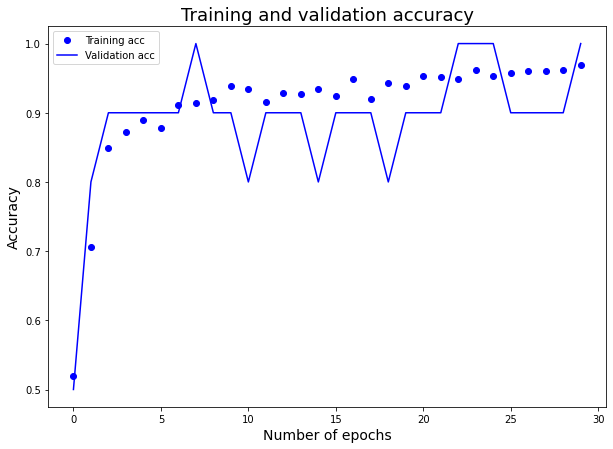

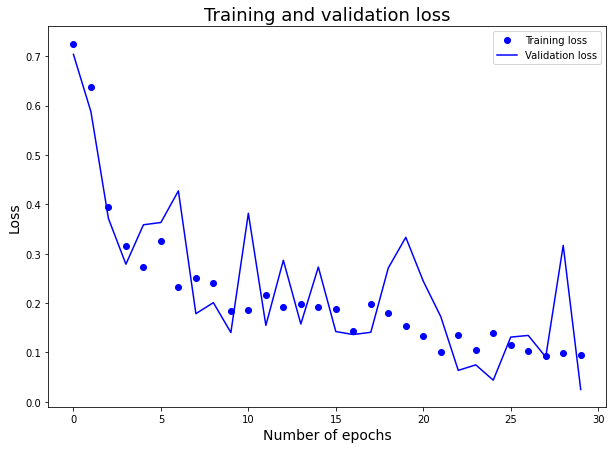

In [51]:
run_model(**params)

Now, increase the number of classes to 4 and include image augmentation.

In [18]:
params = {}
params['num_species'] = 4
params['num_epochs'] = 30
params['train_batch_size'] = 30
params['valid_batch_size'] = 10
params['model'] = create_model()
params['horizontal_flip'] = True
params['rotation_range'] = 45 # set between 0 and 45 degrees

Found 932 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
31/31 [==============================] - 233s 7s/step - loss: 1.3582 - acc: 0.3060 - val_loss: 1.2337 - val_acc: 0.5000
Epoch 2/30
31/31 [==============================] - 12s 387ms/step - loss: 1.0646 - acc: 0.5144 - val_loss: 1.2212 - val_acc: 0.4000
Epoch 3/30
31/31 [==============================] - 12s 387ms/step - loss: 0.9562 - acc: 0.5831 - val_loss: 0.9345 - val_acc: 0.6500
Epoch 4/30
31/31 [==============================] - 12s 375ms/step - loss: 0.7434 - acc: 0.6973 - val_loss: 0.7875 - val_acc: 0.4000
Epoch 5/30
31/31 [==============================] - 12s 373ms/step - loss: 0.7539 - acc: 0.7151 - val_loss: 0.6704 - val_acc: 0.7500
Epoch 6/30
31/31 [==============================] - 12s 380ms/step - loss: 0.5989 - acc: 0.7738 - val_loss: 0.4425 - val_acc: 0.8500
Epoch 7/30
31/31 [==============================] - 12s 377ms/step - loss: 0.5811 - acc: 0.7639 - val_loss: 0.7715 - val_acc: 0.6500
Epoch 8/30
31/31 [==============================] - 12s 378ms/step - lo

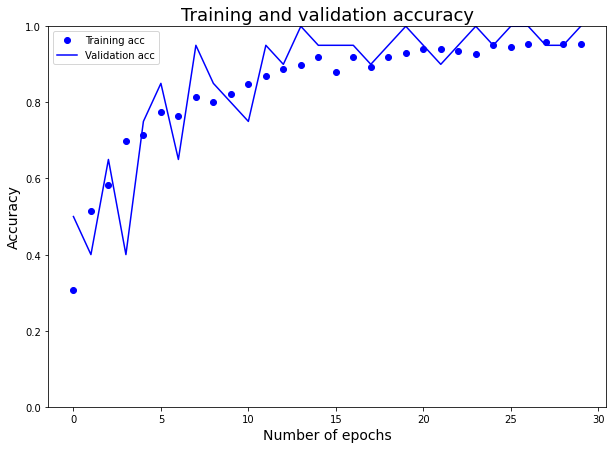

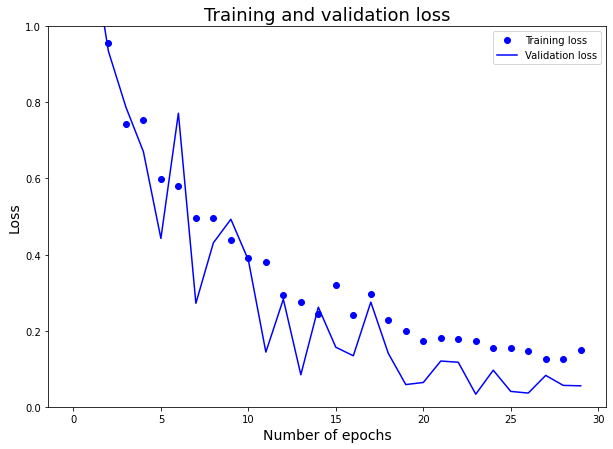

In [19]:
run_model(**params)

Try improving the model by creating a new model that replaces Dropout with Batch Normalization.

In [20]:
#@title

# https://github.com/caroshi/neuralnetworks_art-periods-classification/blob/master/modeling/threeclass--cnn.ipynb

def create_model_batch_norm(): # replace dropout with batch normalization
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  # model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(100, activation='relu'))

  return model

#### We will add the below commented layers later once we know the number of classes we want to use.

# model.add(layers.Dense(train_data['class'].nunique(), activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam', metrics=['acc'])

In [21]:
params = {}
params['num_species'] = 4
params['num_epochs'] = 30
params['train_batch_size'] = 60
params['valid_batch_size'] = 10
params['model'] = create_model_batch_norm()
params['horizontal_flip'] = True
params['rotation_range'] = 45 # set between 0 and 45 degrees

Found 932 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
15/15 [==============================] - 13s 759ms/step - loss: 1.1220 - acc: 0.5539 - val_loss: 1.3422 - val_acc: 0.2500
Epoch 2/30
15/15 [==============================] - 12s 797ms/step - loss: 0.6445 - acc: 0.7557 - val_loss: 1.3484 - val_acc: 0.3500
Epoch 3/30
15/15 [==============================] - 11s 748ms/step - loss: 0.5553 - acc: 0.7970 - val_loss: 1.2992 - val_acc: 0.4500
Epoch 4/30
15/15 [==============================] - 11s 745ms/step - loss: 0.4411 - acc: 0.8314 - val_loss: 1.3447 - val_acc: 0.3500
Epoch 5/30
15/15 [==============================] - 12s 769ms/step - loss: 0.3441 - acc: 0.8716 - val_loss: 1.3383 - val_acc: 0.3000
Epoch 6/30
15/15 [==============================] - 11s 744ms/step - loss: 0.3173 - acc: 0.8888 - val_loss: 1.3197 - val_acc: 0.2500
Epoch 7/30
15/15 [==============================] - 11s 738ms/step - loss: 0.2847 - acc: 0.8979 - val_loss: 1.3659 - val_acc: 0.5000
Epoch 8/30
15/15 [==============================] - 11s 763ms/step - 

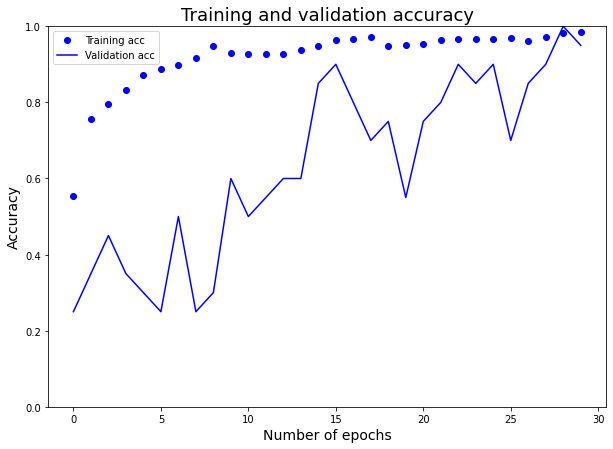

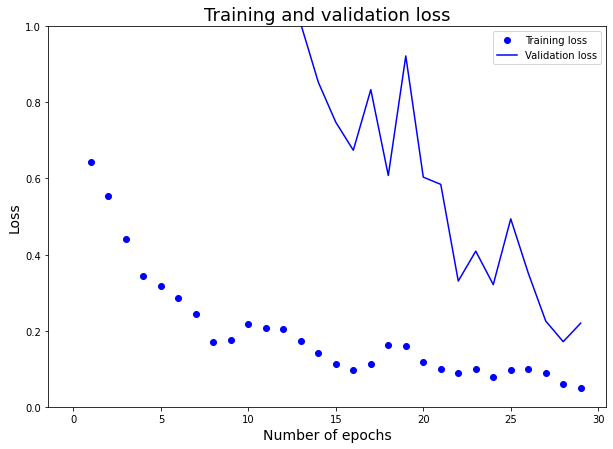

In [22]:
run_model(**params)

In [23]:
params = {}
params['num_species'] = 4
params['num_epochs'] = 30
params['train_batch_size'] = 60
params['valid_batch_size'] = 10
params['model'] = create_model()
params['horizontal_flip'] = True
params['rotation_range'] = 45 # set between 0 and 45 degrees

Found 932 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
15/15 [==============================] - 12s 766ms/step - loss: 1.4366 - acc: 0.2798 - val_loss: 1.3486 - val_acc: 0.4000
Epoch 2/30
15/15 [==============================] - 12s 780ms/step - loss: 1.2906 - acc: 0.3830 - val_loss: 1.1881 - val_acc: 0.4000
Epoch 3/30
15/15 [==============================] - 11s 742ms/step - loss: 1.0695 - acc: 0.4713 - val_loss: 1.2516 - val_acc: 0.3500
Epoch 4/30
15/15 [==============================] - 11s 737ms/step - loss: 1.0340 - acc: 0.4851 - val_loss: 1.0800 - val_acc: 0.4500
Epoch 5/30
15/15 [==============================] - 12s 767ms/step - loss: 0.9536 - acc: 0.5585 - val_loss: 0.9212 - val_acc: 0.5500
Epoch 6/30
15/15 [==============================] - 11s 741ms/step - loss: 0.8490 - acc: 0.6330 - val_loss: 0.9278 - val_acc: 0.5500
Epoch 7/30
15/15 [==============================] - 11s 739ms/step - loss: 0.7761 - acc: 0.6892 - val_loss: 0.6691 - val_acc: 0.7500
Epoch 8/30
15/15 [==============================] - 11s 734ms/step - 

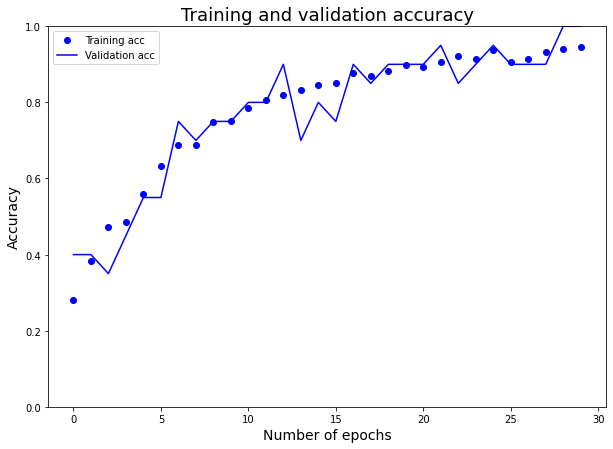

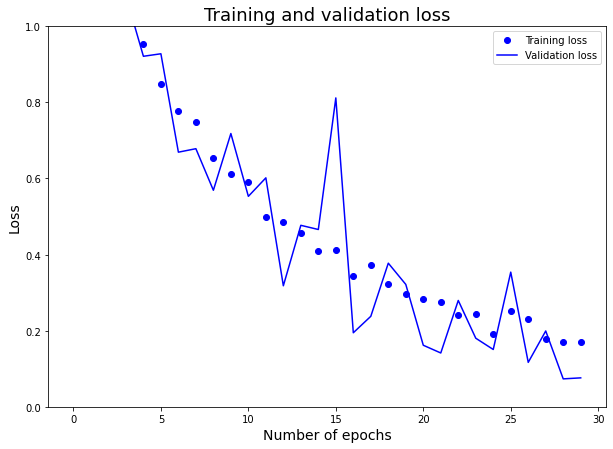

In [24]:
run_model(**params)